# Ejemplo Análisis de Sentimientos

Revisemos un ejemplo del análisis de sentimientos usando R.

# 1. Ejemplo con datos fictivios


In [1]:
# Instalamos y cargamos las bibliotecas necesarias
install.packages("tidytext")
library(tidytext)
library(tidyverse)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
Making 'packages.html' ...
 done

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


    
## Generación de datos 

Creamos un conjunto de datos ficticio de reseñas de clientes. Usaremos en inglés para usar herramientas que vienen pre-entrenadas.         


In [2]:
# Creamos un conjunto de datos ficticio de reseñas de clientes. Usaremos en inglés para usar herramientas que vienen pre-entrenadas. 

reviews <- data.frame(
  customer = c("Customer 1", "Customer 2", "Customer 3", "Customer 4", "Customer 5"),
   review = c("Excellent product, I highly recommend it!",
              "The product was good but the delivery was slow",
              "I am not satisfied with the product, I expected better quality",
              "The product arrived in perfect condition and in record time",
              "I would not recommend this product to others, it did not meet my expectations")
)


## Paso 1: Pre-procesamiento - Tokenizar 
Primero necesitamos tokenizar las palabras de la reseña.



In [3]:

# Tokenizamos las palabras en cada reseña, usamos la función unnest_tokens

reviews_tokens<- reviews %>%
  unnest_tokens(word, review)

head(reviews_tokens, 10)

,customer,word
,<chr>,<chr>
1,Customer 1,excellent
2,Customer 1,product
3,Customer 1,i
4,Customer 1,highly
5,Customer 1,recommend
6,Customer 1,it
7,Customer 2,the
8,Customer 2,product
9,Customer 2,was


In [4]:

# Cargamos un diccionario de sentimientos. En tidytext  vienen tres diccionarios por defecto: bing, ncr y afinn

bing_sentiments <- data("sentiments") # da una valor de positivo o negativo a cada palabra


# Unimos las palabras  de las reseñas con el diccionario de sentimientos

reviews_sentiment_bing <- reviews_tokens %>%
  inner_join(sentiments, by = "word")

head(reviews_sentiment_bing)

,customer,word,sentiment
,<chr>,<chr>,<chr>
1,Customer 1,excellent,positive
2,Customer 1,recommend,positive
3,Customer 2,good,positive
4,Customer 2,slow,negative
5,Customer 3,satisfied,positive
6,Customer 3,better,positive


In [5]:

# Agregamos el puntaje de sentimiento por cada reseña
reviews_scored <- reviews_sentiment_bing %>%
  mutate(value= ifelse(sentiment=="positive", 1, -1)) %>%
  group_by(customer) %>%
  summarize(sentiment_score = sum(value))

# Visualizamos los resultados
head(reviews_scored)


customer,sentiment_score
<chr>,<dbl>
Customer 1,2
Customer 2,0
Customer 3,2
Customer 4,1
Customer 5,1



Dado como generamos el análisis, si el resultado es positivo, el cliente fue positivo si es negativo, negativo y 0 neutral.

Hay dos clientes que tuvieron negativa apreciación, pero lo clasificamos positivamente (cliente 3 y cliente 5), esto porque las combinaciones "not recommend", "not meet", "not satisfied" no fueron clasificadas adecuadamente.

Los mismos autores reconocen esta limitación:

“Not every English word is in the lexicons because many English words are pretty neutral. It is important to keep in mind that these methods do not take into account qualifiers before a word, such as in **”no good” or “not true”**; a lexicon-based method like this is based on unigrams only. For many kinds of text (like the narrative examples below), there are not sustained sections of sarcasm or negated text, so this is not an important effect.”




## Negaciones 

Podemos ver que tenemos un problema con las negaciones. Una forma de lidear con estas es crear una lista de negaciones y vamos a revertir analisis, pero esta vez considerando bigramas.



In [6]:

# Fix Negations
# Create a list to identify the sentiment shifters in the text

negation.words <- c("not",
                    "no",
                    "without",
                    "never",
                    "bad",
                    "none",
                    "never",
                    "nobody",
                    "nowhere",
                    "neither",
                    "nothing"
)


In [7]:

# Podemos agregar otras palabras que queramos ignorar y que no agreguen significado
ignore.words <- data_frame(word = c("product"))


Warning message:
“`data_frame()` was deprecated in tibble 1.1.0.
ℹ Please use `tibble()` instead.”


In [8]:
negaciones <- reviews %>%
            unnest_tokens(bigram, review, token="ngrams", n=2) %>%
            count(bigram, sort=TRUE) %>%
            separate(bigram, c("word1", "word2"), sep = " ") %>%
            filter(word1 %in% negation.words & !word2 %in% stop_words$word) %>%
            inner_join(get_sentiments("bing"), by = c(word2 = "word"))

head(negaciones)

,word1,word2,n,sentiment
,<chr>,<chr>,<int>,<chr>
1,not,recommend,1,positive
2,not,satisfied,1,positive



Es decir, estabamos usando sentimiento positivo para estos casos.


Elegimos las que aparecen en el texto y cambiamos por un sinónimo, para reemplazar. Como no son tantas, este camino es sencillo.

Extraemos el vector que queremos reemplazar.



In [9]:

negaciones2 <- paste(negaciones$word1, negaciones$word2, sep = " ")

head(negaciones2)

[1] "not recommend" "not satisfied"


Definimos manualmente sinonimos



In [10]:
synonyms <- c("bad",
              "bad")



Reemplazamos las negaciones con sus sinónimos.




In [11]:
install.packages("mgsub")
library(mgsub)

review_negations_fix <- mgsub(reviews$review, negaciones2, synonyms)

print(review_negations_fix)


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



[1] "Excellent product, I highly recommend it!"                          
[2] "The product was good but the delivery was slow"                     
[3] "I am bad with the product, I expected better quality"               
[4] "The product arrived in perfect condition and in record time"        
[5] "I would bad this product to others, it did not meet my expectations"


In [12]:

# hacemos un dataframe con los clientes y las reseñas arrechadas

reviews$review_fixed <- review_negations_fix

head(reviews)


,customer,review,review_fixed
,<chr>,<chr>,<chr>
1,Customer 1,"Excellent product, I highly recommend it!","Excellent product, I highly recommend it!"
2,Customer 2,The product was good but the delivery was slow,The product was good but the delivery was slow
3,Customer 3,"I am not satisfied with the product, I expected better quality","I am bad with the product, I expected better quality"
4,Customer 4,The product arrived in perfect condition and in record time,The product arrived in perfect condition and in record time
5,Customer 5,"I would not recommend this product to others, it did not meet my expectations","I would bad this product to others, it did not meet my expectations"


Podemos ver que sigue siendo imperfecto, ya que "expected better" and "did not meet expectations" tampoco están siendo bien clasificados. Si son algunos casos puntuales, podemos agregarlos manualmente, pero con datos a gran escala suele ser más complejo.

Haemos el preemplazo manual y reemplazamos igual que antes:

In [13]:
manual_fix <-c("expected better quality", "did not meet my expectations", "not satisfied")
synonyms <- c("bad", "bad", "bad")

review_negations_fix_manual <- mgsub(reviews$review_fixed, manual_fix, synonyms)

print(review_negations_fix_manual)

[1] "Excellent product, I highly recommend it!"                  
[2] "The product was good but the delivery was slow"             
[3] "I am bad with the product, I bad"                           
[4] "The product arrived in perfect condition and in record time"
[5] "I would bad this product to others, it bad"                 


Ahora usamos el texto reemplazado para repetir el análisis de sentimientos.

In [14]:
reviews$review_fixed2 <- review_negations_fix_manual
head(reviews)

,customer,review,review_fixed,review_fixed2
,<chr>,<chr>,<chr>,<chr>
1,Customer 1,"Excellent product, I highly recommend it!","Excellent product, I highly recommend it!","Excellent product, I highly recommend it!"
2,Customer 2,The product was good but the delivery was slow,The product was good but the delivery was slow,The product was good but the delivery was slow
3,Customer 3,"I am not satisfied with the product, I expected better quality","I am bad with the product, I expected better quality","I am bad with the product, I bad"
4,Customer 4,The product arrived in perfect condition and in record time,The product arrived in perfect condition and in record time,The product arrived in perfect condition and in record time
5,Customer 5,"I would not recommend this product to others, it did not meet my expectations","I would bad this product to others, it did not meet my expectations","I would bad this product to others, it bad"




Y repetimos el análisis de sentimientos.



In [15]:

# volvemos a tokenizar

review_negations_fix<- reviews %>%
  unnest_tokens(word, review_fixed)

#Agregamos el valor desde el diccionario:
  
reviews_sentiment_bing2 <- review_negations_fix %>%
  inner_join(sentiments, by = "word")
  
# Agregamos el puntaje de sentimiento por cada reseña
reviews_scored2 <- reviews_sentiment_bing2 %>%
  mutate(value= ifelse(sentiment=="positive", 1, -1)) %>%
  group_by(customer) %>%
  summarize(sentiment_score = sum(value))

# Visualizamos los resultados
head(reviews_scored2)



customer,sentiment_score
<chr>,<dbl>
Customer 1,2
Customer 2,0
Customer 3,0
Customer 4,1
Customer 5,-1




Ahora claramente el cliente 5 es negativo y el 3 aparece neutral.


Podriams querer saber cuales son las palabras más comunes de los reviews:



In [16]:

# create the words freq table
word.freq.table<- reviews %>% 
  unnest_tokens(word, review) %>%
  anti_join(stop_words) %>%
  anti_join(ignore.words) %>%
  count(word, sort = TRUE)

head(word.freq.table)



Joining with `by = join_by(word)`
Joining with `by = join_by(word)`


,word,n
,<chr>,<int>
1,recommend,2
2,arrived,1
3,condition,1
4,delivery,1
5,excellent,1
6,expectations,1


In [17]:

data("stop_words")
head(stop_words)


word,lexicon
<chr>,<chr>
a,SMART
a's,SMART
able,SMART
about,SMART
above,SMART
according,SMART



Evitamos las stopwords



In [18]:

freq.table <- reviews %>%
    unnest_tokens(word, review) %>%
    anti_join(stop_words) %>%
    anti_join(ignore.words) %>%
    count(word, sort = TRUE)

head(freq.table)


Joining with `by = join_by(word)`
Joining with `by = join_by(word)`


,word,n
,<chr>,<int>
1,recommend,2
2,arrived,1
3,condition,1
4,delivery,1
5,excellent,1
6,expectations,1



Y podemos usar un Word cloud para representar la información.


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: RColorBrewer



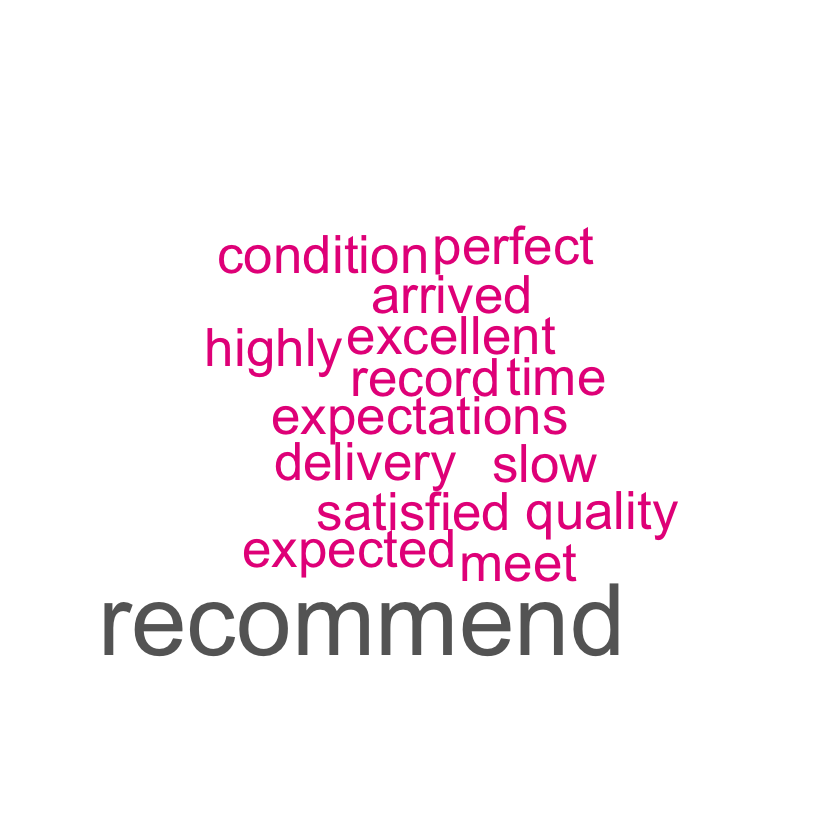

In [19]:
install.packages("wordcloud")
library(wordcloud)

# Plotting a Wordcloud
freq.table %>% 
  #filter(n>40) %>%
  with(wordcloud(word, n,
                 scale = c(5,0.3),
                 colors = brewer.pal(8, "Dark2")))



Como son pocas reviews, no aparece ningun patron.

A veces, tiene más sentido si analizamos bigramas

## Bigramas más frecuentes

                 

```


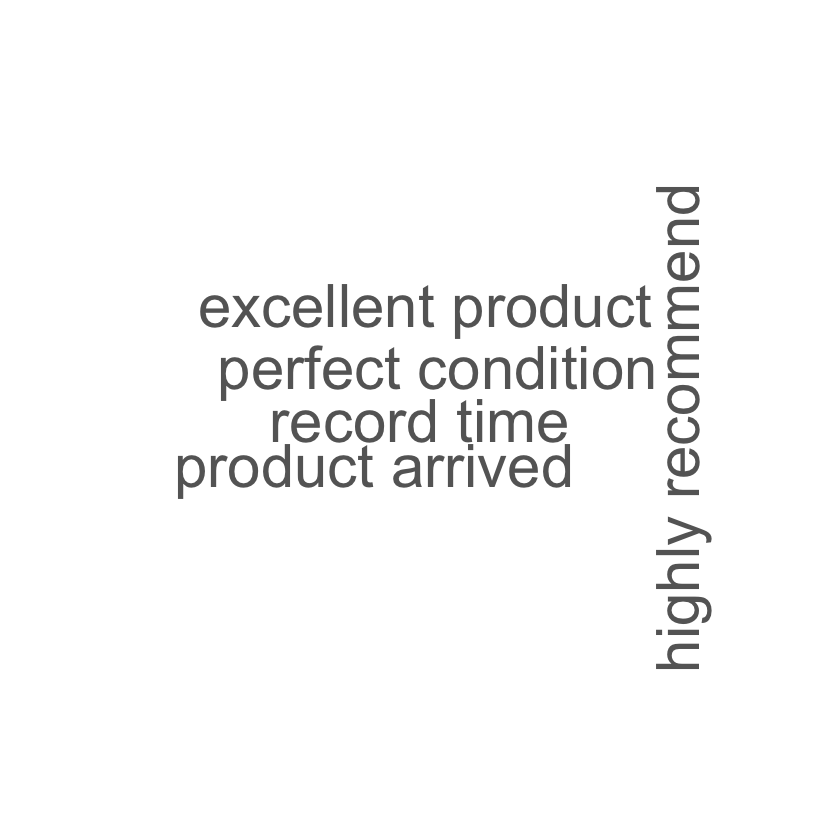

In [20]:

reviews %>%
  unnest_tokens(bigram, review, token = "ngrams", n = 2) %>%
  count(bigram, sort = TRUE) %>%
  separate(bigram, c("word1", "word2"), sep = " ") %>%
  filter(!word1 %in% stop_words$word & !word2 %in% stop_words$word) %>%
  unite(word, word1:word2, sep = " ") %>%
  with(wordcloud(word, n,
                 scale = c(3,0.5),
                 colors = brewer.pal(8, "Dark2")))

# Ejemplo 2: Reseña audifonos datos de Amazon

Vamos a desarrollar un segundo ejemplo con datos reales, siguiendo la implementación de [Üzlem Yuzal](https://medium.com/BozLemuysal/sentiment-analysis-for-product-reviews-ustng-r-74fc767fb16f)

Hay unos datos que acompañan este ejecicio, que fieron extraídos desde Amazon, como review de unos audífonos con cancelación de ruido.

In [23]:
#cargamos los datos

#bose.headphones.reviews <- read.csv("data/data_bose.csv")

bose.headphones.reviews <- read.csv("https://raw.githubusercontent.com/melanieoyarzun/herramientas_aplicadas/refs/heads/main/data/data_bose.csv")


head(bose.headphones.reviews, 3)

X reviewRating reviewDate      reviewFormat Verified_Purchase
1 1 1            October 7, 2018 Color: White TRUE             
2 2 1            August 11, 2016 Color: White TRUE             
3 3 5            August 7, 2017  Color: Black TRUE             
  reviewHeadline                                                                  
1 DO NOT BUY IF YOU INTEND TO TALK OUTSIDE - MISLEADING PRODUCT INFO\n            
2 Great Sound, Poor Quality, Poor Customer Service\n                              
3 The BEST Headphones I Have Ever Used!!!\n                                       
  reviewText                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Primero limpiamos algunos de los datos:

In [22]:
# Ignora los revisores que no compraron el producto.
# Verified_Purchase debe ser TRUE

bose.headphones.reviews <- filter(bose.headphones.reviews, Verified_Purchase==TRUE)


# Limpiamos los textos y preparamos para el análisis. Usamos Stop words del paquete tidytext

data("stop_words")

bose.headphones.reviews.text <- bose.headphones.reviews %>%
  select(reviewText)


# Encoding
# chequeamos que el encoding del texto sea consistente.

stri_enc_mark(bose.headphones.reviews.text$reviewText)
bose.headphones.reviews.text$reviewText <- sapply(bose.headphones.reviews.text$reviewText,
                                                  function(row) iconv(row,
                                                                      "latin1",
                                                                      "ASCII",
                                                                      sub = " "))


# todo a minúsculas
bose.headphones.reviews.text$reviewText <- tolower(bose.headphones.reviews.text$reviewText)

# transformamos contracciones wasn't=was not, can't=can not, etc..
bose.headphones.reviews.text$reviewText <- gsub("wasn[\u2019']t", "was not", bose.headphones.reviews.text$reviewText)
bose.headphones.reviews.text$reviewText <- gsub("won[\u2019']t", "will not", bose.headphones.reviews.text$reviewText)
bose.headphones.reviews.text$reviewText <- gsub("can[\u2019']t", "can not", bose.headphones.reviews.text$reviewText)
bose.headphones.reviews.text$reviewText <- gsub("didn[\u2019']t", "did not", bose.headphones.reviews.text$reviewText)
bose.headphones.reviews.text$reviewText <- gsub("don[\u2019']t", "do not", bose.headphones.reviews.text$reviewText)
bose.headphones.reviews.text$reviewText <- gsub("I[\u2019']m", "I am", bose.headphones.reviews.text$reviewText)
bose.headphones.reviews.text$reviewText <- gsub("[\u2019']ve", " have", bose.headphones.reviews.text$reviewText) 
bose.headphones.reviews.text$reviewText <- gsub("[\u2019|']s", "", bose.headphones.reviews.text$reviewText)
bose.headphones.reviews.text$reviewText <- gsub("[\u2019']re", " are", bose.headphones.reviews.text$reviewText)
bose.headphones.reviews.text$reviewText <- gsub("[\u2019']ll", " will", bose.headphones.reviews.text$reviewText)

# Si observamos errores comunes de tipeo, los podemos agregar acá

bose.headphones.reviews.text$reviewText<- gsub("canceling", "cancelling", bose.headphones.reviews.text$reviewText)

bose.headphones.reviews.text$reviewText <- gsub("cancellation", "cancelling", bose.headphones.reviews.text$reviewText)


# Arreglamos negaciones
# Creamos una lista para identificar negaciones


negation.words <- c("not",
                    "no",
                    "without",
                    "never",
                    "bad",
                    "none",
                    "never",
                    "nobody",
                    "nowhere",
                    "neither",
                    "nothing"
)

# Cambiamos la polaridad en las palabras que tienen negaciones

shifted.words <- bose.headphones.reviews.text %>%
  unnest_tokens(bigram, reviewText, token = "ngrams", n = 2)%>%
  count(bigram, sort = TRUE) %>%
  separate(bigram, c("word1", "word2"), sep = " ")%>%
  filter(word1 %in% negation.words & !word2 %in% stop_words$word)%>%
  inner_join(get_sentiments("bing"), by = c(word2 = "word"))%>%
  mutate(sentiment = ifelse(sentiment == "positive", 1, -1)) %>%
  mutate(score = sentiment * n) %>%
  mutate(word2 = reorder(word2, score))

shifted.words

# Elegimos las palabras con mas cambios de significado por negación:

negated.phrases <- c("not worth", 
                     "not noise",
                     "no issues",
                     "no complaints",
                     "not disappoint",
                     "not disappointed",
                     "not cheap",
                     "no regrets"
                     
)
# Y proponemos sinónimos:

synonyms <- c("expensive",
              "functional",
              "cool",
              "satisfied",
              "satisfied",
              "satisfied",
              "expensive",
              "satisfied"
)
# Reemplazamos las negaciones con sus sinónimos.

bose.headphones.reviews.text <- mgsub(bose.headphones.reviews.text$reviewText, negated.phrases, synonyms) %>%
  dplyr::as_data_frame() %>%
  rename(reviewText = value)


# Podemos agregar otras palabras que se repiten mucho, pero que no agregan significado. En este caso, vinculadas a la marca y nombre del producto:

ignore.words <- data_frame(word = c("sound", "bose", "headphones","noise", "soundlink"))


ERROR: Error in stri_enc_mark(bose.headphones.reviews.text$reviewText): no se pudo encontrar la función "stri_enc_mark"


Acá tenemos mucha más información que antes.
Revisemos que palabras son más frecuentes.


In [ ]:
# Creemos una tabla de frequencia de palabras:

word.freq.table<- bose.headphones.reviews.text %>% 
  unnest_tokens(word, reviewText) %>%
  anti_join(stop_words) %>%
  anti_join(ignore.words) %>%
  count(word, sort = TRUE)
head(word.freq.table, 10)

Joining with `by = join_by(word)`
Joining with `by = join_by(word)`


word,n
<chr>,<int>
quality,632
comfortable,354
bluetooth,331
love,276
battery,272
cancelling,233
music,220
phone,215
pair,210


In [ ]:
#numero total de palabras
length(word.freq.table$word)

[1] 4351

Para visualizar mejor, hacemos nube de palabras:


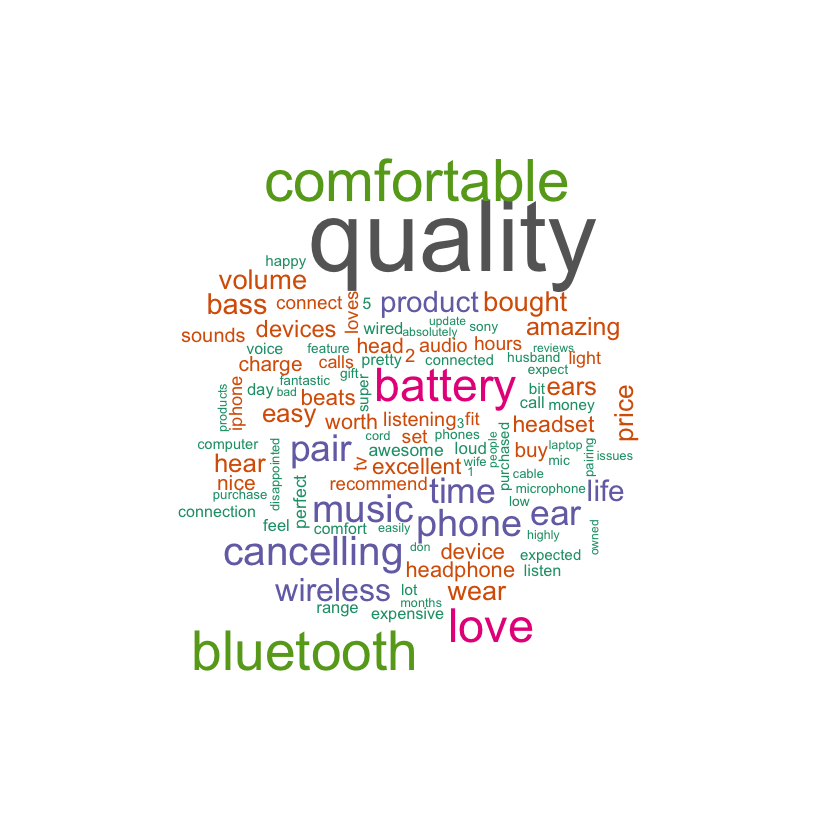

In [ ]:
# Grafiquemos una nube de palabras
word.freq.table %>% 
  filter(n>40) %>%
  with(wordcloud(word, n,
                 scale = c(5,0.3),
                 colors = brewer.pal(8, "Dark2")))

Podemos visualizar bigramas también:

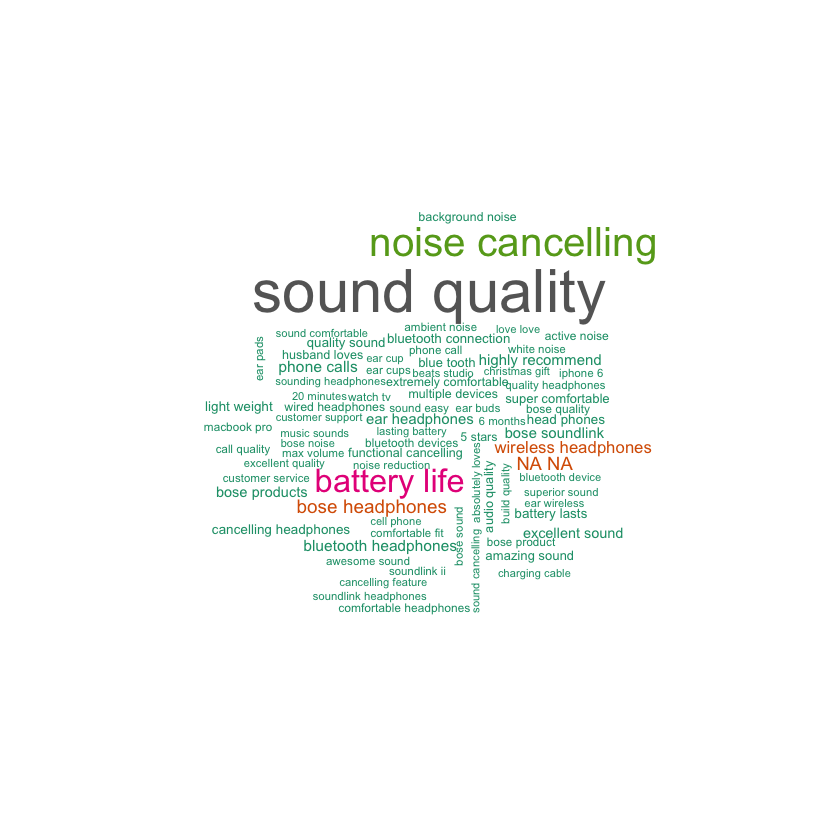

In [ ]:
# Bigramas más comunes
bose.headphones.reviews.text %>%
  unnest_tokens(bigram, reviewText, token = "ngrams", n = 2) %>%
  count(bigram, sort = TRUE) %>%
  separate(bigram, c("word1", "word2"), sep = " ") %>%
  filter(!word1 %in% stop_words$word & !word2 %in% stop_words$word) %>%
  filter(n>7) %>%
  unite(word, word1:word2, sep = " ") %>%
  with(wordcloud(word, n,
                 scale = c(3,0.5),
                 colors = brewer.pal(8, "Dark2")))


Extraemos las palabras más comunes positibas y negativas con el diccionario BING



Joining with `by = join_by(word)`
Joining with `by = join_by(word)`
Joining with `by = join_by(word)`
Warning message in inner_join(., get_sentiments("bing")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 9193 of `x` matches multiple rows in `y`.
ℹ Row 5908 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


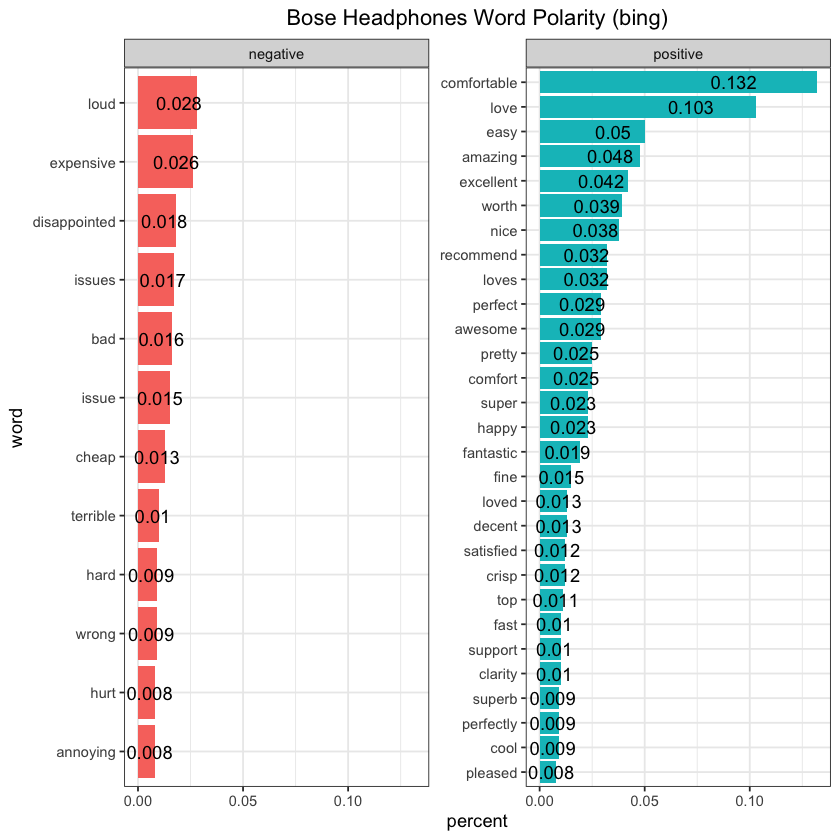

In [ ]:
# Las palabras más comunes positivas y negativas utilizando diccionario Bing

bose.headphones.reviews.text %>% 
  unnest_tokens(word, reviewText) %>%
  anti_join(stop_words) %>%
  anti_join(ignore.words) %>%
  inner_join(get_sentiments("bing")) %>%
  count(word, sentiment, sort = TRUE) %>%
  filter(n > 20) %>%
  mutate(word = reorder(word, n)) %>%
  mutate(percent = round(n/sum(n), 3)) %>%
  ggplot(aes(x = word, y = percent, fill = sentiment, label = percent)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~sentiment, scales = "free_y") +
  geom_text(aes(y = 0.7*percent)) +
  labs(title = "Bose Headphones Word Polarity (bing)") +
  coord_flip() + 
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5))


